## OpenStreetMap Project for Nano degree
*by Jie Hu, jie.hu.ds@gmail.com*

This is a project for Udacity [Nano-degree](https://classroom.udacity.com/nanodegrees/) P3 part. 
In this project I will clean the open street data of [San Francisco Bay Area](https://mapzen.com/data/metro-extracts/metro/san-francisco-bay_california/) and write into MongoDB database, after which yields some visualization work. 

The structure of this report is:

1. Problems in dataset
2. Data Cleaning
3. Discusion on improvements I made
4. Data Overview and Wrangling with MongoDB
5. Additional Ideas
6. Conclusion


### Part 1. Problems in dataset


In [1]:
# import package
# Load packages and raw data file
import re
from collections import defaultdict
import json
import xml.etree.cElementTree as ET
import pprint
import numpy as np
import datetime as dt

osm_file = 'sf_sample.osm'

After I get sample data, I find out there are several problems in the dataset.

1. data are listed within different tags, which might have different structure: 

In [2]:
# type and number of nodes
dic = defaultdict(int)

for _, elem in ET.iterparse(osm_file):
    dic[elem.tag] +=1
print dic

defaultdict(<type 'int'>, {'node': 47149, 'nd': 56388, 'member': 370, 'tag': 17356, 'relation': 56, 'way': 5512, 'osm': 1})


2. keys, like 'exit_to', 'exit_to:left', 'exit_to:right' can be involved in one list
3. keys, like 'lat' and 'lon' can be saved in a dictionary to seperate from other attributes:
~~~~
{
    'position': {'lat': ..., 
                 'lon': ...
                 }
}
~~~~
4. value of 'timestamp' is just a string, which can be transformed into: 
~~~~
{
    'time': {'year':...,
             'month':...,
             'day':...,
             ...}
}
~~~~
5. keys, like 'sfgov.org', 'addr.source' can not be used in MongoDB because they include '.'
6. keys, like 'addr:country', 'addr:state' should be transformed into:

~~~~
{
    'addr': {'city': ...
             'country':...
             'state':...
 ...
}
~~~~
instead of:
~~~~
{
    'addr:city':...
    'addr:country':...
    'addr:state':...
}
~~~~


### Part 2. Data Cleaning

Then I check data structure of each node, and write a function to process each part respectively.

**Problems 1-4:**

The method 'attach_node' will process node according to its type and problems and then save into a dictionary, 'temp_dic'. Then after this, the processed data of such node, in the form of dictionary will be appended to a list.

In [3]:
def attach_node(temp_dic, node_name):
    for node in elem.iter(node_name):
            # add uid, version, changeset, user, id
            for key in ['uid', 'version', 'changeset', 'user', 'id']:    
                if node.attrib.has_key(key):
                    temp_dic[key] = node.attrib[key]

            # add position with latitude and longitude
            if node.attrib.has_key('lat') and node.attrib.has_key('lon'):
                temp_dic['position'] = {'lat': float(node.attrib['lat']),
                                        'lon': float(node.attrib['lon'])}

            # timestamp into year, month, day, hour, minute, second
            if node.attrib.has_key('timestamp'):
                time = dt.datetime.strptime(node.attrib['timestamp'], "%Y-%m-%dT%H:%M:%SZ")
                temp_dic['time'] = {'year': time.year,
                                    'month': time.month,
                                    'day': time.day,
                                    'hour': time.hour,
                                    'minute': time.minute}         # Here I think not necessary to extract second


            # attach data from key 'tag'
            for tag in node.iter('tag'):

                # attach tag value IN exit_to list
                exit_arr = []
                for key in ['exit_to','exit_to:left','exit_to:right']:
                    if tag.attrib['k'] == key:
                        exit_arr.append(tag.attrib['v'])

                if exit_arr != []:
                    temp_dic['exit_to'] = exit_arr

                # attach tag value NOT IN exit_to list
                if not tag.attrib['k'] in ['exit_to','exit_to:left','exit_to:right']:
                    temp_dic[tag.attrib['k']] = tag.attrib['v']

            temp_dic['node_type'] = node_name

In [4]:
# Process data

dic_sample = []

for _, elem in ET.iterparse(osm_file):

    temp_dic = {}
    
    
    # attach data from key 'member'
    for member in elem.iter('member'):
        for key in member.keys():
            if member.attrib[key] != "":
                temp_dic[key] = member.attrib[key]
            else:
                temp_dic[key] = None
    
    # attach data from key 'node'
    attach_node(temp_dic, 'node')
    
    # attach data from key 'relation', it's exactly the same as 'node'
    attach_node(temp_dic, 'relation')
    
    # attach data from key 'way', it's exactly the same as 'node'
    attach_node(temp_dic, 'way')
    
    if temp_dic != {}:
        dic_sample.append(temp_dic)
        

Now dic_sample almost have cleaned data:

In [5]:
dic_sample[:2]

[{'changeset': '22950379',
  'id': '281266',
  'node_type': 'node',
  'position': {'lat': 37.5601845, 'lon': -122.3025783},
  'time': {'day': 15, 'hour': 18, 'minute': 55, 'month': 6, 'year': 2014},
  'uid': '1660455',
  'user': 'juergenb22',
  'version': '6'},
 {'changeset': '3949010',
  'id': '30029483',
  'node_type': 'node',
  'position': {'lat': 37.7019213, 'lon': -122.0341958},
  'time': {'day': 23, 'hour': 0, 'minute': 44, 'month': 2, 'year': 2010},
  'uid': '14293',
  'user': 'KindredCoda',
  'version': '13'}]

** Problem 5**
- keys, like 'sfgov.org', 'addr.source' can not be used in MongoDB because they include '.'
- keys, like 'addr:country', 'addr:state' should be transformed into:

~~~~
{
    'addr': {'city': ...
             'country':...
             'state':...
 ...
}
~~~~

Then will be solved by below replacement, my idea is not just process address data, but also all data structured in such way, now I need to check what these key like:

In [6]:
post_style = re.compile(r'.*:.*')
key_set = set()
for item in dic_sample:
    for key, value in item.items():
        if post_style.match(key) and key not in key_set:
            key_set.add(key)

# print key_set

Result of print:
~~~~
{'FG:COND_INDEX', 
 'FG:GPS_DATE',
 ...
 'Tiger:HYDROID',
 'Tiger:MTFCC',
 'abandoned:place',
 ...
 'addr:city',
 ..
 }
~~~~

Here's the method to do the processing:

In [7]:
# change key:sub_key pairs into key: {subkey1:..., subkey2:...,...}

re_style = re.compile(r'.+:.+')

for item in dic_sample:
    
    key_set = set()
    
    for item_key in item.keys():
        if re_style.match(item_key):
            item_subkeys = item_key.split(':')
            if len(item_subkeys) >= 2:
                if item_subkeys[0] not in key_set:
                    key_set.add(item_subkeys[0])
                    item[item_subkeys[0]] = {}
            
                item[item_subkeys[0]][item_subkeys[1]] = item.pop(item_key)
                    
            


** Problem 6**

Some keys, for example: {'addr.source', 'sfgov.org'} is not suitable to be used in MongoDB so I replace them.

In [8]:
post_style = re.compile(r'.+\..+')
for item in dic_sample:
    for key, value in item.items():
        if key == 'addr.source':
            if item.has_key('addr'):
                item['addr']['source'] = item.pop('addr.source')
            else:
                item['addr_source'] = item.pop('addr.source')
        elif key == 'sfgov.org':
            item['sfgov'] = item.pop('sfgov.org')


Now dic_sample saved our data in a pretty good format, so I can store it into a JSON file.

In [9]:
import json
with open('data_example.json', 'w') as fp:
    json.dump(dic_sample, fp)

#### Part 3: Discussion on improvements I made

There are 6 improvements made to the original dataset, but they might have risk. In this section I gonna discuss the pros and cons of these improvements one by one.

* Improve 1 to: data are listed within different tags, which might have different structure

  * Pros:
    * it's very clear and fast to do the improvements by add them directly into a list of dictionary based on the key I already know.
    * adding key 'node_type' can both keep uniform structure for each node and keep information of its node type for future usage


  * Cons:
    * I use same method based on the assumption that the nodes, like 'node', 'way', 'member' and 'relation' have similar structure of keys and corresponding values. It's possible some typo or unintended error or, eventually, some designed difference might occur within each node. 
  
  * Suggestion for future:
    * In future, if to explore further, a script to exam structure of each node is necessary.


* Improve 2 to: keys, like 'exit_to', 'exit_to:left', 'exit_to:right' can be involved in one list


  * Pros:
    * After merge these keys into one list, it's pretty clear to know all exit of node/way values
    
  * Cons:
    * It's hard to tell if it's going straightforward or to left or to right
    
  * Suggesition for future:
    * Better create a dictionary with structure:
    
    ~~~~
    {
        'exit_to': {'type': 'left', 'value': '...'}
    }
    ~~~~
    


* Improve 3 to: keys, like 'lat' and 'lon' can be saved in a dictionary to seperate from other attributes:
~~~~
{
    'position': {'lat': ..., 
                 'lon': ...
                 }
}
~~~~

  * Pros:
    It makes data logically structured and meanwhile keep all information. Accessing the data of position is also very easy.

  * Cons:
    I don't see any cons for this improvements.


* Improve 4 to: value of 'timestamp' is just a string, which can be transformed into: 
~~~~
{
    'time': {'year':...,
             'month':...,
             'day':...,
             ...}
}
~~~~

  * Pros:
    It makes data logically structured and meanwhile keep all information of time. 
    
  * Cons:
    It might take 5 or more times of storage to store the data because the original data is just a string, but now it is seperated into 5 values: year, month, day, hour, minute.
    
  * Suggestions for future


* Improve 5 to: keys, like 'sfgov.org', 'addr.source' can not be used in MongoDB because they include '.'

  * Pros:
    It prohibits potential error by adding keys like 'addr.source' directly to MongoDB because '.' means subkey of key or zooming in key of a document in MongoDB.
    
  * Cons:
    I don't see if there's any con. It's a must step before we write data into database.
    

* Improve 6 to: keys, like 'addr:country', 'addr:state' should be transformed into:

~~~~
{
    'addr': {'city': ...
             'country':...
             'state':...
 ...
}
~~~~
instead of:
~~~~
{
    'addr:city':...
    'addr:country':...
    'addr:state':...
}
~~~~

  * Pros:
    It makes data logically structured and meanwhile keep all information of address. 
    
  * Cons:
    It might take much more times of storage to store the data because the original data is just a string, but now it is seperated into several different values.
  
  * Future suggestion:
    Be careful about the size of database before write in data.
  

Beside the pros and cons discussed above, it's possible to have other unseen problems. Any ideas are welcome to email me: [jie.hu.ds@gmail.com](mailto: jie.hu.ds@gmail.com)

### Part 4. Data Overview and Wrangling with MongoDB


Now start my MongoDB, connect with python client, and insert the data:


In [10]:
from pymongo import MongoClient

In [11]:
client = MongoClient('localhost:27017')
db = client.openstreetmap

for item in dic_sample:
    db.openstreetmap.insert_one(item)
    

Basic data information:

sf_sample.osm ..................... 102.5 MB
san-francisco_california.osm........1.01  GB    

(Because it takes too long time to process whole data on my old mac, here I will only use sample data, which is large enough for this project. Ideas will be the same)

data_example.json .... 132.1 MB
                                                
#### Number of documents

In [14]:
db.openstreetmap.find().count()

585600

#### Number of nodes

In [15]:
db.openstreetmap.find({"node_type":"node"}).count()

518637

#### Number of way

In [16]:
db.openstreetmap.find({"node_type":"way"}).count()

60629

All are exactly match what we get in front of this report:

{'node': 471488, ..., 'way': 55115})

Number of 'way' is almost same, I will just ignore the only one difference of count.

#### Number of unique users

In [17]:
len(db.openstreetmap.distinct('user'))

1541

Here I use below methods to write my query pipelines:

In [18]:
def aggregate(db, pipeline):
    return [doc for doc in db.openstreetmap.aggregate(pipeline)]

In [19]:
def make_pipeline():
    pipeline = [{"$group": {"_id": "$user",
                                        "count": {"$sum": 1}}},
                            {"$sort": {"count": -1}},
                            {"$limit": 10}
]
    return pipeline

#### Top 10 most contribution users

In [20]:
import pprint
pipeline = make_pipeline()
result = aggregate(db, pipeline)
pprint.pprint(result)

[{u'_id': u'ediyes', u'count': 101137},
 {u'_id': u'Luis36995', u'count': 78167},
 {u'_id': u'Rub21', u'count': 43527},
 {u'_id': u'RichRico', u'count': 24717},
 {u'_id': u'calfarome', u'count': 20438},
 {u'_id': u'oldtopos', u'count': 18451},
 {u'_id': u'KindredCoda', u'count': 16608},
 {u'_id': u'karitotp', u'count': 14981},
 {u'_id': u'samely', u'count': 13886},
 {u'_id': u'abel801', u'count': 11921}]


### Part 5: Additional Ideas

#### Most contribution hour

In [21]:
def make_pipeline():
    pipeline = [{"$group": {"_id": "$time.hour",
                                        "count": {"$sum": 1}}},
                            {"$sort": {"count": -1}},
                            {"$limit": 24}
]
    return pipeline

pipeline = make_pipeline()
result = aggregate(db, pipeline)
result_dic = {}
for item in result:
    result_dic[item['_id']] = item['count']

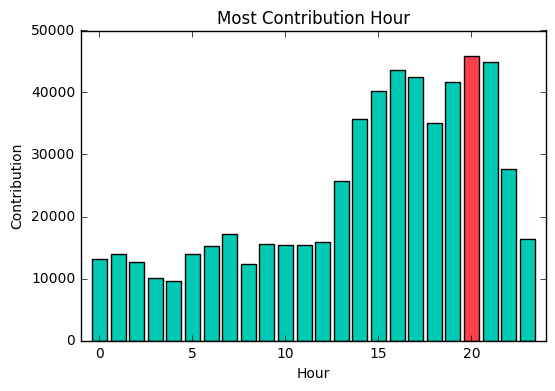

In [23]:
import matplotlib.pyplot as plt

values = result_dic.values()
clrs = ['#01cab4' if (x < max(values)) else '#ff3f49' for x in values ]

plt.bar(range(len(result_dic)), values, align='center', color = clrs)
plt.title("Most Contribution Hour")
plt.xlabel("Hour")
plt.ylabel("Contribution")
plt.xlim(-1,24)
plt.show()

#### most contribution month

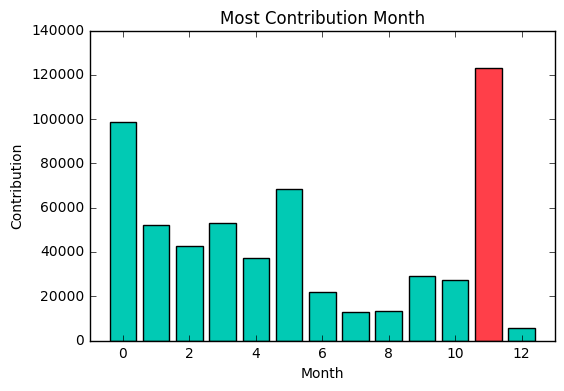

In [24]:
def make_pipeline():
    pipeline = [{"$group": {"_id": "$time.month",
                                        "count": {"$sum": 1}}},
                            {"$sort": {"count": -1}},
                            {"$limit": 24}
]
    return pipeline

pipeline = make_pipeline()
result = aggregate(db, pipeline)
result_dic = {}
for item in result:
    result_dic[item['_id']] = item['count']

values = result_dic.values()
clrs = ['#01cab4' if (x < max(values)) else '#ff3f49' for x in values ]

plt.bar(range(len(result_dic)), values, align='center', color = clrs)
plt.title("Most Contribution Month")
plt.xlabel("Month")
plt.ylabel("Contribution")
plt.xlim(-1,13)
plt.show()

#### Top 10 appearing amenities

In [25]:
def make_pipeline():
    pipeline = [{"$match":{"amenity":{"$exists":1}}},
                {"$group": {"_id": "$amenity",
                                        "count": {"$sum": 1}}},
                {"$sort": {"count": -1}},
                {"$limit": 10}
]
    return pipeline


pipeline = make_pipeline()
result = aggregate(db, pipeline)
result

[{u'_id': u'parking', u'count': 457},
 {u'_id': u'restaurant', u'count': 358},
 {u'_id': u'school', u'count': 151},
 {u'_id': u'bench', u'count': 147},
 {u'_id': u'place_of_worship', u'count': 125},
 {u'_id': u'cafe', u'count': 103},
 {u'_id': u'post_box', u'count': 76},
 {u'_id': u'fast_food', u'count': 61},
 {u'_id': u'bank', u'count': 60},
 {u'_id': u'bicycle_parking', u'count': 57}]

#### Most popular cuisines

In [26]:
def make_pipeline():
    pipeline = [{"$match":{"amenity":{"$exists":1}}},
                {"$group": {"_id": "$cuisine",
                            "count": {"$sum": 1}}},
                {"$sort": {"count": -1}},
                {"$limit": 10}
]
    return pipeline


pipeline = make_pipeline()
result = aggregate(db, pipeline)
result

[{u'_id': None, u'count': 1922},
 {u'_id': u'mexican', u'count': 34},
 {u'_id': u'coffee_shop', u'count': 30},
 {u'_id': u'pizza', u'count': 24},
 {u'_id': u'chinese', u'count': 21},
 {u'_id': u'burger', u'count': 17},
 {u'_id': u'japanese', u'count': 15},
 {u'_id': u'italian', u'count': 15},
 {u'_id': u'american', u'count': 15},
 {u'_id': u'thai', u'count': 13}]

While ignoring the None type, we can say that the coffee shops are most popular cuisine.

#### Part 6: Conclusion


This project offers me very effecient way to wrangle data. I've learned extracting, transforming and loading technicals and I found a lot of interesting ideas in the city I'm living. I'm amazed by the data produced by people.

Regarding the possible improvements of this report, I think below approaches might be a good choice:
- Time distribution of top10 contributors
- Most frequent contribution regions, I think bounding boxes of district in San Francisco are required
- Distribution of most popular cuisines, we can see this from how people with different culture background might be distributed